In [2]:
import numpy as np
from torchvision.datasets import CocoDetection
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append("/home/tyfei/cyroem")
import utils
import torch
import importlib 
import json
importlib.reload(utils)
import modules
import pycocotools.coco
import pycocotools.mask
import torchvision.transforms.v2 as transforms
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation, ConditionalDetrForObjectDetection,ConditionalDetrConfig,ConditionalDetrForSegmentation

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tomo=[] 
memb=[]
ribo = [] 
ribo_mask = []
name = []
for k in ["sull20241102_AA", "20241102_BSA1_tilt", "sull20240525_tilt", "sull20241102_AA", "sull20241102_BSA2", "sull20241122_AA", "sull20241203_rest", "zhaoxs20240805_0821_denoised", "zhaoxs20240901", "zhaoxs20240920"]:
    for i in os.listdir("/mnt/panbz/lab/transforemer_model/pretrain_data/%s/tomo/"%k):
        if not i.endswith(".mrc"):
            continue
        target = i[:i.find(".")]
        tomo.append(os.path.join("/mnt/panbz/lab/transforemer_model/pretrain_data/%s/tomo/"%k, i))
        ribo.append("/mnt/panbz/lab/transforemer_model/pretrain_data/%s/ribo/cor_done.star"%k)
        ribo_mask.append(target)
        if target in name:
            name.append(target+"(2)")
        else:
            name.append(target)
        for j in os.listdir("/mnt/panbz/lab/transforemer_model/pretrain_data/%s/memb"%k):
            if target in j:
                memb.append(os.path.join("/mnt/panbz/lab/transforemer_model/pretrain_data/%s/memb"%k, j))
                break  
    print(k)
    df_targets = pd.DataFrame({"tomo":tomo, "memb":memb, "ribo":ribo, "ribo_mask":ribo_mask, "name":name})

sull20241102_AA
20241102_BSA1_tilt
sull20240525_tilt
sull20241102_AA
sull20241102_BSA2
sull20241122_AA
sull20241203_rest
zhaoxs20240805_0821_denoised
zhaoxs20240901
zhaoxs20240920


In [12]:
a, b = np.unique(df_targets["name"], return_counts=True)
a[b.argsort()]

array(['slltr0033_9', 'slltr0022_9', 'slltr0023_9', 'slltr0024_9',
       'slltr0025_9', 'slltr0026_9', 'slltr0027_9', 'slltr0028_9',
       'slltr0029_9', 'slltr0030_9', 'slltr0031_9', 'slltr0032_9',
       'slltr0021_9', 'slltr0034_9', 'slltr0035_9', 'slltr0036_9',
       'slltr0037_9', 'slltr0038_9', 'slltr0039_9', 'slltr0040_9',
       'slltr0041_9', 'slltr0042_9', 'slltr0043_9', 'slltr0010_9',
       'slltb0040_9', 'slltb0041_9', 'slltr0001_9', 'slltr0002_9',
       'slltr0003_9', 'slltr0004_9', 'slltr0005_9', 'slltr0006_9',
       'slltr0007_9', 'slltr0008_9', 'slltr0009_9', 'slltr0044_9',
       'slltr0011_9', 'slltr0012_9', 'slltr0013_9', 'slltr0014_9',
       'slltr0015_9', 'slltr0016_9', 'slltr0017_9', 'slltr0018_9',
       'slltr0019_9', 'slltr0020_9', 'sll_0013_9', 'zxs_0053_9',
       'zxs_0054_9', 'zxs_0055_9', 'zxs_0056_9', 'zxs_0057_9',
       'zxs_0058_9', 'zxs_0059_9', 'zxs_0070_9', 'sll_0009_9',
       'sll_0011_9', 'sll_0012_9', 'zxs_0052_9', 'sll_0015_9',
       's

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2])

In [ ]:
len(np.unique(df["name"]))

In [ ]:
# def loadModel(path, checkpoint="last.ckpt"):
#     with open(os.path.join(path, "config.json"), "r") as f:
#         configs = json.load(f)

#     model = getModel(configs)

#     ckpt = torch.load(os.path.join(path, checkpoint))["state_dict"]
#     need_del = []
#     p = [j for j, _ in model.named_parameters()]
#     for i in ckpt:
#         if i not in p or ckpt[i].shape != model.state_dict()[i].shape:
#             need_del.append(i)
#     for i in need_del:
#         del ckpt[i]
#     print(need_del)
#     model.load_state_dict(ckpt, strict=False)

#     return model

### test dataset

In [ ]:
dfs = {}
for i in ["TS_005.pkl", "TS_023.pkl", "TS_031.pkl", "sllt0039_9.pkl", "sllt0051_9.pkl", "sllt0081_9.pkl"]:
    dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
                            "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/"+i,
                            is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13,14, 15]}, single_class={"all":False}, add_classname=True, maxsize=800, require_mask=True) 
    content = []
    print(i)
    for j in dataset:
        content.extend(j["labels"]["all"]["names"])
    d = {i:j for i,j in zip(*np.unique(content, return_counts=True))}
    dfs[i] = d
    # print(np.unique(content, return_counts=True)) 
    # break
df = pd.DataFrame(dfs)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
TS_005.pkl
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
TS_023.pkl
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
TS_031.pkl
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
sllt0039_9.pkl
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
sllt0051_9.pkl
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
sllt0081_9.pkl


### test pretrain

In [3]:
model_pretrain = utils.loadModel("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6_pretrain_map2/", "epoch=249-total_validate_loss=2.1114.ckpt")

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

model at stage  stage 1


/home/feity/cryoem/utils.py:483: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(configs["model"]["load"], map_location="cpu")


incompatible parameters ['model.merge.class_embed.0.weight', 'model.merge.class_embed.0.bias', 'model.merge.class_embed.1.weight', 'model.merge.class_embed.1.bias', 'model.merge.class_embed.2.weight', 'model.merge.class_embed.2.bias', 'model.merge.class_embed.3.weight', 'model.merge.class_embed.3.bias', 'model.merge.class_embed.4.weight', 'model.merge.class_embed.4.bias', 'model.merge.class_embed.5.weight', 'model.merge.class_embed.5.bias']
finish loading parameters


/home/feity/cryoem/utils.py:879: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(os.path.join(path, checkpoint))["state_dict"]


incompatible parameters []
finish loading parameters


In [5]:
params = torch.load("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/pretrain_map_two/last.ckpt")
state_dict = params["state_dict"]

/tmp/ipykernel_4063/2540741708.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  params = torch.load("/mnt/panbz/lab/transforemer_model/train_data/training/results/deforma

In [7]:
for i, j in state_dict.items():
    print(i, j.shape)

model.merge.model.level_embed torch.Size([4, 256])
model.merge.model.backbone.conv_encoder.model.conv1.weight torch.Size([64, 3, 7, 7])
model.merge.model.backbone.conv_encoder.model.bn1.weight torch.Size([64])
model.merge.model.backbone.conv_encoder.model.bn1.bias torch.Size([64])
model.merge.model.backbone.conv_encoder.model.bn1.running_mean torch.Size([64])
model.merge.model.backbone.conv_encoder.model.bn1.running_var torch.Size([64])
model.merge.model.backbone.conv_encoder.model.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.0.bn1.weight torch.Size([64])
model.merge.model.backbone.conv_encoder.model.layer1.0.bn1.bias torch.Size([64])
model.merge.model.backbone.conv_encoder.model.layer1.0.bn1.running_mean torch.Size([64])
model.merge.model.backbone.conv_encoder.model.layer1.0.bn1.running_var torch.Size([64])
model.merge.model.backbone.conv_encoder.model.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
model.merge.model.backbone.c

In [61]:
dataset = modules.CocoTraverse(
                            # "/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
                            "/mnt/panbz/lab/transforemer_model/pretrain_data/clean_dataset/", 
                            # "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/separate/sllt0051_9.pkl",
                            # "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/train6.pkl", 
                            "/mnt/panbz/lab/transforemer_model/pretrain_data/clean_dataset/convex_hull_annotation/zxs_0041_9.pkl",
                            is_npy=True, filter_class={"merge":[1, 3]}, single_class={"merge":False}, add_classname=True, maxsize=800, require_mask=True, norm="hist", filtermin=5)

loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


/home/feity/cryoem/utils.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image * 255).type(torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


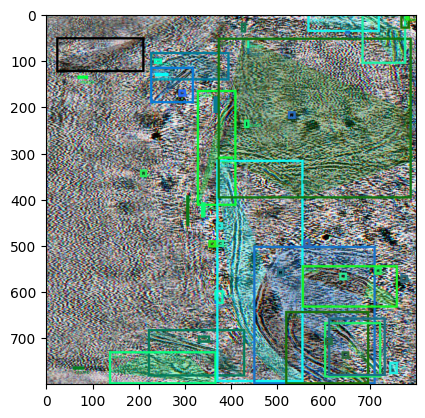

In [69]:
data = dataset[30]
utils.drawannotation(data["pixel_values"], data["labels"]["merge"])

In [70]:
data["labels"]["merge"]["masks"].shape

torch.Size([48, 800, 800])

In [ ]:
from concurrent.futures import  ThreadPoolExecutor
import time

# Example task function
def task_function(task_id):
    print(f"Processing task {task_id}")
    for i in range(10000):
        for j in range(10000):
            pass# Simulate some work (e.g., I/O operation)
    return f"Task {task_id} completed"

# Main script
if __name__ == "__main__":
    # Task pool: 200 tasks
    task_pool = range(1, 201)  # Task IDs from 1 to 200

    # Thread pool with 10 threads
    with ThreadPoolExecutor(max_workers=10) as executor:
        # Submit tasks to the thread pool and get results
        results = list(executor.map(task_function, task_pool))

    # Print results
    print("\nAll tasks completed!")
    for result in results:
        print(result)


Processing task 1
Processing task 2
Processing task 3
Processing task 4
Processing task 5
Processing task 6
Processing task 7
Processing task 8
Processing task 9
Processing task 10
Processing task 11
Processing task 12
Processing task 13
Processing task 14
Processing task 15
Processing task 16
Processing task 17
Processing task 18
Processing task 19
Processing task 20
Processing task 21
Processing task 22
Processing task 23
Processing task 24
Processing task 25
Processing task 26
Processing task 27
Processing task 28
Processing task 29
Processing task 30
Processing task 31
Processing task 32
Processing task 33
Processing task 34
Processing task 35
Processing task 36
Processing task 37
Processing task 38
Processing task 39
Processing task 40
Processing task 41
Processing task 42
Processing task 43
Processing task 44
Processing task 45
Processing task 46
Processing task 47
Processing task 48
Processing task 49
Processing task 50
Processing task 51
Processing task 52
Processing task 53
Pr

In [75]:
for i in range(10000):
    for j in range(10000):
        pass

In [10]:
data["pixel_values"].shape

torch.Size([3, 800, 800])

In [11]:
output = model_pretrain(
        pixel_values=data["pixel_values"].unsqueeze(0).float(),
        pixel_mask=data["pixel_mask"].unsqueeze(0).float(),
    )

In [54]:
_output = output["merge"]
logits = _output["logits"].squeeze(0)
pred_boxes = _output["pred_boxes"].squeeze(0)
prob = torch.sigmoid(logits)
res = prob > torch.tensor([0.60, 0.30, 0.50, 0.30, 0.30])
res = res.any(dim=1)

In [55]:
bbox = pred_boxes[res]
bbox = torch.zeros_like(bbox) 
bbox[:, 0] = pred_boxes[res][:, 0] - pred_boxes[res][:, 2] / 2
bbox[:, 1] = pred_boxes[res][:, 1] - pred_boxes[res][:, 3] / 2
bbox[:, 2] = pred_boxes[res][:, 0] + pred_boxes[res][:, 2] / 2
bbox[:, 3] = pred_boxes[res][:, 1] + pred_boxes[res][:, 3] / 2
bbox *= torch.tensor([data["pixel_values"].shape[2], data["pixel_values"].shape[1], data["pixel_values"].shape[2], data["pixel_values"].shape[1]]) 
bbox = bbox.long()

In [56]:
labels = ["test" for i in range(bbox.shape[0])] 

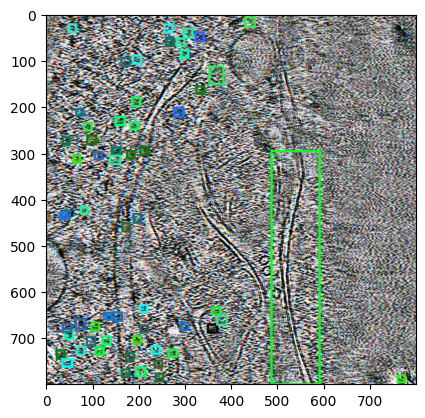

In [57]:
labels = {"bboxes": bbox, "labels": labels} 
utils.drawannotation(data["pixel_values"], labels)

### test train

In [337]:
model_finetuned = utils.loadModel("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6_pretrain_map1/", "last.ckpt")

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

model at stage  stage 1


/home/feity/cryoem/utils.py:483: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(configs["model"]["load"], map_location="cpu")
/home/feity/cryoem/utils.py:877: 

In [351]:
dataset = modules.CocoTraverse(
                            # "/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
                            "/mnt/panbz/lab/transforemer_model/pretrain_data/clean_dataset/", 
                            # "/mnt/panbz/lab/transforemer_model/pretrain_data/dataset/annotations/separate/sllt0051_9.pkl",
                            # "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/train6.pkl", 
                            "/mnt/panbz/lab/transforemer_model/pretrain_data/clean_dataset/annotations/sllta0033_9.pkl",
                            is_npy=True, filter_class={"merge":[3, 4, 7, 12, 14]}, single_class={"merge":False}, add_classname=True, maxsize=800, require_mask=True, norm="hist", filtermin=5)

loading annotations into memory...
Done (t=7.02s)
creating index...
index created!


/home/feity/cryoem/utils.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image * 255).type(torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


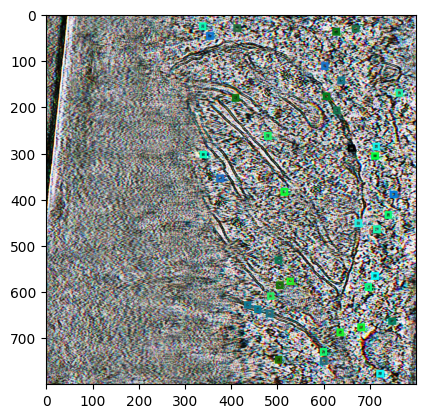

In [353]:
data = dataset[30]
utils.drawannotation(data["pixel_values"], data["labels"]["merge"])

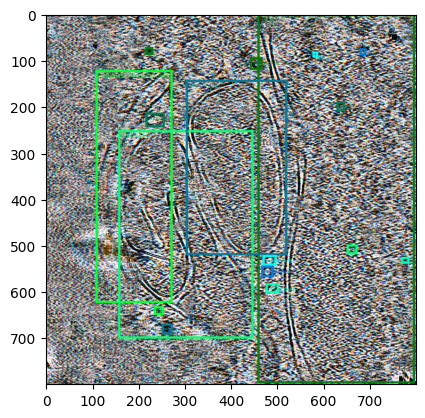

In [328]:
data = dataset[50]
utils.drawannotation(data["pixel_values"], data["labels"]["merge"])

In [347]:
output = model_finetuned(
        pixel_values=data["pixel_values"].unsqueeze(0).float(),
        pixel_mask=data["pixel_mask"].unsqueeze(0).float(),
    )

In [350]:
for i, j in model_finetuned.named_parameters():
    print(i, j.shape)

model.merge.model.level_embed torch.Size([4, 256])
model.merge.model.backbone.conv_encoder.model.conv1.weight torch.Size([64, 3, 7, 7])
model.merge.model.backbone.conv_encoder.model.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
model.merge.model.backbone.conv_encoder.model.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.1.conv1.weight torch.Size([64, 256, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
model.merge.model.backbone.conv_encoder.model.layer1.1.conv3.weight torch.Size([256, 64, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.2.conv1.weight torch.Size([64, 256, 1, 1])
model.merge.model.backbone.conv_encoder.model.layer1.2.conv2.weight torch.Size([64, 64, 3, 3

In [348]:
_output = output["merge"]
logits = _output["logits"].squeeze(0)
pred_boxes = _output["pred_boxes"].squeeze(0)
prob = torch.sigmoid(logits)
res = prob > torch.tensor([0.45, 0.45, 0.45, 0.45, 0.45])
res = res.any(dim=1)
bbox = pred_boxes[res]
bbox = torch.zeros_like(bbox) 
bbox[:, 0] = pred_boxes[res][:, 0] - pred_boxes[res][:, 2] / 2
bbox[:, 1] = pred_boxes[res][:, 1] - pred_boxes[res][:, 3] / 2
bbox[:, 2] = pred_boxes[res][:, 0] + pred_boxes[res][:, 2] / 2
bbox[:, 3] = pred_boxes[res][:, 1] + pred_boxes[res][:, 3] / 2
bbox *= torch.tensor([data["pixel_values"].shape[2], data["pixel_values"].shape[1], data["pixel_values"].shape[2], data["pixel_values"].shape[1]]) 
bbox = bbox.long()

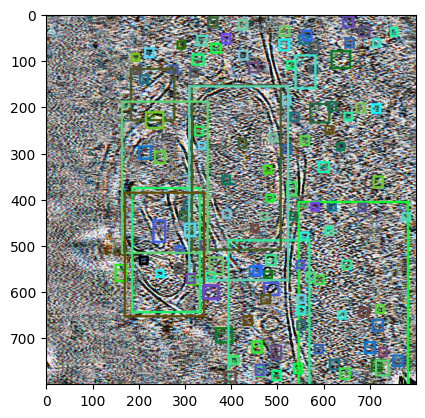

In [349]:
labels = ["test" for i in range(bbox.shape[0])] 
labels = {"bboxes": bbox, "labels": labels} 
utils.drawannotation(data["pixel_values"], labels)

In [ ]:
model = utils.loadModel("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6_test_with_crop", "last.ckpt") 
for i in ["TS_005.pkl", "TS_023.pkl", "TS_031.pkl", "sllt0039_9.pkl", "sllt0051_9.pkl", "sllt0081_9.pkl"]:
    dataset = modules.CocoTraverse("/mnt/panbz/lab/transforemer_model/train_data/training/data/", 
                            "/mnt/panbz/lab/transforemer_model/train_data/training/data/annotations/"+i,
                            is_npy=True, filter_class={"all":[1,2,3,4,5,6,7,8,9,10,11,12,13]}, single_class={"all":False}, add_classname=True, maxsize=800, require_mask=True) 

    retdict = utils.buildStage2(model, dataset, (800, 800), 0.2, model_names=["all"], has_none=False, single=True)
    d = utils.convertStage2Dataset(retdict)
    torch.save(d, "/mnt/panbz/lab/transforemer_model/train_data/training/results_0.2/deformable/fold6_test_with_crop/res/"+i.split(".")[0]+"_stage2dataset.pkl")
    torch.save(retdict, "/mnt/panbz/lab/transforemer_model/train_data/training/results_0.2/deformable/fold6_test_with_crop/res/"+i.split(".")[0]+"_stage2.pkl")

In [3]:
graph = torch.load("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6/res/TS_005_stage2dataset.pkl") 
retdict = torch.load("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6/res/TS_005_stage2.pkl")
model = utils.loadModel("/mnt/panbz/lab/transforemer_model/train_data/training/results/deformable/fold6_stage2", "epoch=124-validate_loss=1.1173-validate_acc=0.7607.ckpt")

/tmp/ipykernel_34830/1695539048.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load("/mnt/panbz/lab/transforemer_model/train_data/training/results/deforma

model at stage  stage 2


/home/feity/cryoem/utils.py:471: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t = torch.load(configs["model"]["load"], map_location="cpu")
/home/feity/cryoem/utils.py:852: 

In [33]:
retdict["images"][15].shape

torch.Size([3, 800, 800])

In [34]:
retdict.keys()

dict_keys(['feature', 'label', 'masks', 'box_mask', 'boxes', 'item_id', 'images', 'sample_mapping'])

In [4]:
model.stage = "stage 2"
res = model(graph.x, graph.edge_index)
res.keys()

dict_keys(['predict', 'box', 'edge', 'embeddings'])

In [36]:
need = []
for i in retdict["sample_mapping"]:
    if retdict["sample_mapping"][i] == 16:
        need.append(i)

In [37]:
graph.edge_index.shape

torch.Size([2, 25882])

In [38]:
class E(object):
    pass
r = E()

In [39]:
r.logits = res["predict"][need]
r.pred_boxes = res["box"][need]
r.embeddings = res["embeddings"][need]

In [40]:
r.logits = r.logits.unsqueeze(0)
r.pred_boxes = r.pred_boxes.unsqueeze(0)
r.embeddings.shape

torch.Size([50, 272])

In [41]:
target_sizes = [(800, 800)]
results = utils.postSegmentationTreatment(r, 0.5, target_sizes,mask_threshold=None, style="None")
result = results[0]

In [42]:
keep = utils.bbnms(0.2, result["boxes"], result["scores"], result["labels"])
for i in result:
    result[i] = result[i][keep]

/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


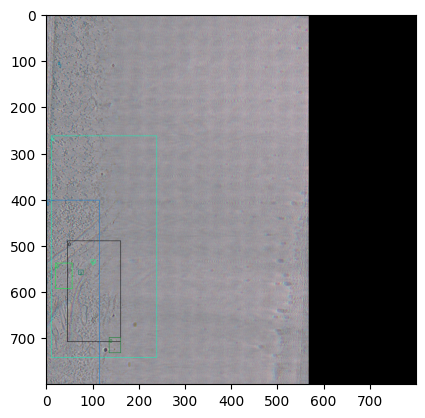

In [43]:
img = retdict["images"][16]
t = utils.toTarget(result, img.shape[1:])
# t["masks"] = output > 0.5
img = img.cpu().numpy() 
img = (img*255).astype(int)
importlib.reload(utils)
utils.drawannotation(img, t)